In [4]:
import tqdm
from PIL import ImageDraw
import PIL
import os
from shutil import copyfile, rmtree
from IPython.display import Image 

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
import random
from shutil import copyfile

import warnings
warnings.simplefilter('ignore')


%matplotlib inline

In [2]:
data_dir = "./locator"

In [3]:
torch.cuda.current_device()

0

# Validation & Training Sets

Move images from the src directories into the train/validation directories

## Setup Terrain Data

In [4]:
src_terrain = "./locator/data/terrain-verified/"
review_terrain = "./locator/data/review/terrain/"
dst_terrain_train = "./locator/data/train/terrain/"
dst_terrain_valid = "./locator/data/valid/terrain/"

for f in os.listdir(dst_terrain_train):
    os.remove(dst_terrain_train+f)
for f in os.listdir(dst_terrain_valid):
    os.remove(dst_terrain_valid+f)
    
for f in os.listdir(src_terrain):
    if random.randint(0,5) >= 1:
        shutil.copy(src_terrain+f, dst_terrain_train+f)
    else:
        shutil.copy(src_terrain+f, dst_terrain_valid+f)

for f in os.listdir(review_terrain):
    if not ".png" in f:
        continue
    if random.randint(0,5) >= 1:
        shutil.copy(review_terrain+f, dst_terrain_train+f)
    else:
        shutil.copy(review_terrain+f, dst_terrain_valid+f)


      
train_num = len(os.listdir(dst_terrain_train))
print("Training terrain: "+str(train_num))
valid_num = len(os.listdir(dst_terrain_valid))
print("Validation terrain: "+str(valid_num))
valid_num = len(os.listdir(dst_terrain_valid))
print("Total terrain: "+str(valid_num+train_num))

Training terrain: 7149
Validation terrain: 1400
Total terrain: 8549


## Setup Player Data

In [5]:
src_player = "./locator/data/player-verified/"
review_player = "./locator/data/review/player/"
dst_player_train = "./locator/data/train/player/"
dst_player_valid = "./locator/data/valid/player/"

for f in os.listdir(dst_player_train):
    os.remove(dst_player_train+f)
for f in os.listdir(dst_player_valid):
    os.remove(dst_player_valid+f)
    
for f in os.listdir(src_player):
    if random.randint(0,5) >= 1:
        shutil.copy(src_player+f, dst_player_train+f)
    else:
        shutil.copy(src_player+f, dst_player_valid+f)
        
for f in os.listdir(review_player):
    if not ".png" in f:
        continue
    if random.randint(0,5) >= 1:
        shutil.copy(review_player+f, dst_player_train+f)
    else:
        shutil.copy(review_player+f, dst_player_valid+f)


train_num = len(os.listdir(dst_player_train))
print("Training player: "+str(train_num))
valid_num = len(os.listdir(dst_player_valid))
print("Validation player: "+str(valid_num))
valid_num = len(os.listdir(dst_player_valid))
print("Total player: "+str(valid_num+train_num))

Training player: 1104
Validation player: 229
Total player: 1333


# Create Data Batch

Collect the 30x30 images which were split from in-game mini-maps. The model predicts if a player is present in the center 10x10 pixels, the extra image around the center 10x10 gives more context for the model's prediction. 

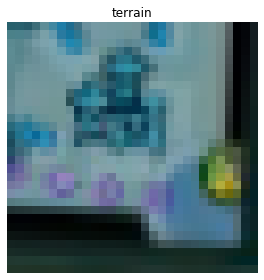

In [6]:
tfms = get_transforms(max_rotate=45, max_zoom=1.1, max_warp=None)
data = ImageDataBunch.from_folder(
    data_dir+"/data", classes=["player", "terrain"], bs=64, ds_tfms=tfms)
data.show_batch(1)

# Train the Model

We train several models, and keep the one with the highest performance. It is still unknown why some models are better, but one explanation from the fastai course may be the initialization of parameters.

## Model Training

In [8]:
lr = 0.02

learn = create_cnn(data, models.resnet18, metrics=[accuracy])
gc.collect()
learn.callbacks = [SaveModelCallback(
    learn, every='improvement', mode='min', name='best')]
learn.fit_one_cycle(1, lr)
learn.unfreeze()
learn.fit_one_cycle(15, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.345018,0.192191,0.919583,00:03


Better model found at epoch 0 with valid_loss value: 0.19219090044498444.


epoch,train_loss,valid_loss,accuracy,time
0,0.220880,0.182861,0.925107,00:04
1,0.206663,0.177058,0.926949,00:04
2,0.189958,0.169204,0.931246,00:04
3,0.193401,0.181690,0.925721,00:04
4,0.175694,0.155995,0.932474,00:04
5,0.154059,0.159636,0.930632,00:04
6,0.146907,0.161171,0.934929,00:04
7,0.137798,0.134312,0.951504,00:04
8,0.130778,0.141772,0.946593,00:04
9,0.119716,0.132027,0.950890,00:04


Better model found at epoch 0 with valid_loss value: 0.18286146223545074.
Better model found at epoch 1 with valid_loss value: 0.17705826461315155.
Better model found at epoch 2 with valid_loss value: 0.16920411586761475.
Better model found at epoch 4 with valid_loss value: 0.1559949815273285.
Better model found at epoch 7 with valid_loss value: 0.13431160151958466.
Better model found at epoch 9 with valid_loss value: 0.13202744722366333.
Better model found at epoch 10 with valid_loss value: 0.12690967321395874.
Better model found at epoch 11 with valid_loss value: 0.12140900641679764.
Better model found at epoch 13 with valid_loss value: 0.11992233246564865.


best loss: 9.7

## Full Minimap Test

Display the model's predictions for an entire minimap.

In [2]:
grid_size = 5

def empty_dir(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(e)


def draw_grid(draw, labels):
    fill = (0, 255, 255, 96)
    for l in labels:
        x = l[0] * grid_size
        y = l[1] * grid_size
        if l[2] == "terrain":
            continue
        draw.rectangle((x, y, x + grid_size, y + grid_size), fill=fill)


def draw_preds(filename, grids):
    img = PIL.Image.open(filename)

    overlay = PIL.Image.new('RGBA', img.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)
    draw_grid(draw, grids)
    out = PIL.Image.alpha_composite(img, overlay)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(img);
    ax[1].imshow(out);
#     imshow(np.asarray(out))


def get_predictions(learner, predictions):
    # Predict the grid image types
    tmp_dir = data_dir + "/tmp"
    test = ImageList.from_folder(tmp_dir)
    learner.data.add_test(test)
    preds = learner.get_preds(ds_type=DatasetType.Test)
    num_preds = len(preds)
    z = 0

    # Identify the grids which are player squares
    for i in range(len(preds[0])):
        max_index = 0
        max_score = 0
        for p in range(len(preds[0][i])):
            if preds[0][i][p] > max_score:
                max_index = p
                max_score = preds[0][i][p]
                
        category = str(learn.data.classes[max_index])
        if category == "terrain":
            continue
        img = test.items[i]
        fname = img.stem
        num = int(fname.split("-")[1])
        name = fname.split("-")[0]
        x = num//1000
        y = num % 1000
        predictions[name].append((x, y, category))

    empty_dir(tmp_dir)
    return predictions


def get_grids(learner, filenames):
    num_files = len(filenames)
    predictions = {}
    # Split the image into grids and save the components to the tmp directory.
    tmp_dir = data_dir+"/tmp"
    empty_dir(tmp_dir)
    numfiles = len(filenames)
    for l in range(numfiles):
        f = filenames[l]
        if not ".png" in f:
            continue
        im = PIL.Image.open(f)
        imgwidth, imgheight = im.size
        base = os.path.basename(f)
        fname = os.path.splitext(base)[0]
        predictions[fname] = []
        for i in range(0, imgheight, grid_size):
            for j in range(0, imgwidth, grid_size):
                box = (j-14, i-14, j + 16, i + 16)
                a = im.crop(box)
                a.save(data_dir+f"/tmp/{fname}-{j*1000//grid_size+i//grid_size}.png")

    predictions = get_predictions(learner, predictions)

    return predictions

In [10]:
i = 0

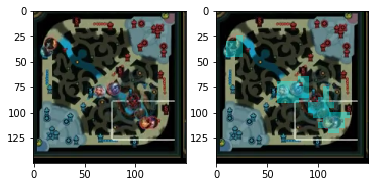

In [13]:
i += 50
s = str(i)
s = "0"*(3-len(s)) + s
filenames = [
    f"games/hka_lk_worlds_2019/full/hka_lk_worlds_2019_0000000{s}.png"]
grids = get_grids(learn, filenames)
base = os.path.basename(filenames[0])
fname = os.path.splitext(base)[0]
draw_preds(filenames[0], grids[fname])

In [14]:
model_path = 'models/'
learn.export(model_path+"locator.pth")

## Create Full Map Coordinates

Use the model we trained to predict the coordinates of each player in the maps. This csv will be used as the target in the final map prediction model.

In [27]:
def predict_positions(subdir):
    z = 0
    for game in os.listdir("./games"):
        z += 1
        try:
            game_dir = f"./games/{game}/{subdir}"
            maps = os.listdir(game_dir)
        except:
            print(game + "is not a game directory")
            continue
        
        if f"{subdir}_{game}.csv" in maps:
            print(str(z) + game + " positions already detected")
            continue
        print(str(z) + game + " detecting positions")
        maps = [m for m in maps if ".png" in m]
        maps = [f"{game_dir}/{m}" for m in maps]
        if len(maps) < 200:
                print(game + "is not a game directory")
                continue
        
        grids = get_grids(learn, maps)

        fnames = []
        tags = []
        for k, v in grids.items():
            v = [f"{g[0]};{g[1]};{g[2]}" for g in v]
            v.sort()
            v = " ".join(v)
            fnames.append(k)
            tags.append(v)

        df = pd.DataFrame({'image_name': fnames, 'tags': tags},
                          columns=['image_name', 'tags'])
        convert_dict = {'image_name': str, 'tags': str}
        df = df.astype(convert_dict)
        df.replace('', np.nan, inplace=True) # Remove the mini-maps with no players.
        df.dropna(subset=['tags'], inplace=True)
        df.to_csv(f"{game_dir}/{subdir}_{game}.csv", index=False)
    

In [28]:
predict_positions("full")
predict_positions("team")

1ahq_ig_1_worlds_oct_12_2019 positions already detected
2lec_2020_og_so4 positions already detected
3c9_hka_1_worlds_oct_13_2019 positions already detected
4gam_spy_1_worlds_oct_12_2019 positions already detected
5ahq_dwg_1_worlds_oct_13_2019 positions already detected
6ig_tl_1_worlds_oct_12_2019 positions already detected
7c9_grf_1_worlds_oct_15_2019 positions already detected
8lec_2020_mad_vit detecting positions


9g2_hka_1_worlds_oct_18_2019 positions already detected
10dfm_spy_worlds_2019 positions already detected
11hka_isg_3_2019 detecting positions


12rng_skt_1_worlds_oct_13_2019 positions already detected
13mmm_uol_worlds_2019 positions already detected
14lec_2020_g2_vit detecting positions


15grf_hka_1_worlds_oct_18_2019 positions already detected
16fla_ryl_worlds_2019 positions already detected
17lec_2020_vit_sk detecting positions


18ahq_dwg_1_worlds_oct_20_2019 positions already detected
19fpx_jt_1_worlds_oct_12_2019 positions already detected
20fnc_skt_2_worlds_oct_19_2019 positions already detected
21hka_isg_1_2019 detecting positions


22lk_mg_2_worlds_2019 positions already detected
23lec_2020_fnc_msf detecting positions


24dwg_ryl_worlds_2019 positions already detected
25c9_hka_1_worlds_oct_18_2019 positions already detected
26hka_lk_2_worlds_2019 positions already detected
27ahq_ig_1_worlds_oct_20_2019 positions already detected
28lk_mg_worlds_2019 positions already detected
29hka_lk_worlds_2019 positions already detected
30dwg_tl_1_worlds_oct_20_2019 positions already detected
31cg_skt_1_worlds_oct_19_2019 positions already detected
32lec_2020_mad_xl detecting positions


33fpx_gam_1_worlds_oct_15_2019 positions already detected
34dwg_lk_worlds_2019 positions already detected
35lec_2020_msf_reg detecting positions


36spy_uol_3_2019 detecting positions


37jt_spy_1_worlds_oct_15_2019 positions already detected
38lec_2020_g2_sk detecting positions


39ahq_tl_1_worlds_oct_20_2019 positions already detected
40lec_2020_so4_xl detecting positions


41spy_uol_2_2019 detecting positions


42spy_uol_6_2019 detecting positions


43cg_ryl_3_worlds_2019 positions already detected
44fnc_skt_1_worlds_oct_19_2019 positions already detected
45hka_isg_4_2019 detecting positions


46ig_tl_1_worlds_oct_20_2019 positions already detected
47g2_grf_2_worlds_oct_18_2019 positions already detected
48cg_fnc_1_worlds_oct_13_2019 positions already detected
49fnc_rng_1_worlds_oct_13_2019 positions already detected
50dwg_fla_worlds_2019 positions already detected
51cg_fnc_2_worlds_oct_19_2019 positions already detected
52lec_2020_fnc_og detecting positions


53fla_ryl_3_worlds_2019 positions already detected
54fla_ryl_2_worlds_2019 positions already detected
55lec_2020_msf_sk detecting positions


56jt_spy_1_worlds_oct_17_2019 positions already detected
57lec_2020_g2_mad detecting positions


58fpx_gam_1_worlds_oct_17_2019 positions already detected
59dwg_lk_4_worlds_2019 positions already detected
60c9_grf_1_worlds_oct_18_2019 positions already detected
61fpx_spy_1_worlds_oct_17_2019 positions already detected
62dwg_tl_1_worlds_oct_12_2019 positions already detected
63cg_ryl_1_worlds_2019 positions already detected
64gam_spy_1_worlds_oct_17_2019 positions already detected
65rng_skt_2_worlds_oct_19_2019 positions already detected
66cg_ryl_2_worlds_2019 positions already detected
67spy_uol_5_2019 detecting positions


68fnc_skt_1_worlds_oct_12_2019 positions already detected
69cg_rng_1_worlds_oct_19_2019 positions already detected
70dwg_ig_1_worlds_oct_20_2019 positions already detected
71spy_fpx_1_worlds_oct_17_2019 positions already detected
72cg_mmm_worlds_2019 positions already detected
73hka_isg_2_2019 detecting positions


74hka_mg_worlds_2019 positions already detected
75dwg_lk_3_worlds_2019 positions already detected
76cg_skt_1_worlds_oct_15_2019 positions already detected
77spy_uol_4_2019 detecting positions


78dwg_lk_2_worlds_2019 positions already detected
79isg_spy_worlds_2019 positions already detected
80gam_jt_1_worlds_oct_17_2019 positions already detected
81lec_2020_rge_xl detecting positions


82fpx_jt_1_worlds_oct_17_2019 positions already detected
83grf_g2_1_worlds_oct_13_2019 positions already detected
84fnc_rng_1_worlds_oct_19_2019 positions already detected
85g2_grf_1_worlds_oct_18_2019 positions already detected
86c9_g2_1_worlds_oct_18_2019 positions already detected
87cg_rng_1_worlds_oct_12_2019 positions already detected
88cg_uol_worlds_2019 positions already detected
89lec_2020_og_rge detecting positions


1ahq_ig_1_worlds_oct_12_2019 positions already detected
2lec_2020_og_so4 positions already detected
3c9_hka_1_worlds_oct_13_2019 positions already detected
4gam_spy_1_worlds_oct_12_2019 positions already detected
5ahq_dwg_1_worlds_oct_13_2019 positions already detected
6ig_tl_1_worlds_oct_12_2019 positions already detected
7c9_grf_1_worlds_oct_15_2019 positions already detected
8lec_2020_mad_vit detecting positions


9g2_hka_1_worlds_oct_18_2019 positions already detected
10dfm_spy_worlds_2019 positions already detected
11hka_isg_3_2019 detecting positions


12rng_skt_1_worlds_oct_13_2019 positions already detected
13mmm_uol_worlds_2019 positions already detected
14lec_2020_g2_vit detecting positions


15grf_hka_1_worlds_oct_18_2019 positions already detected
16fla_ryl_worlds_2019 positions already detected
17lec_2020_vit_sk detecting positions


18ahq_dwg_1_worlds_oct_20_2019 positions already detected
19fpx_jt_1_worlds_oct_12_2019 positions already detected
20fnc_skt_2_worlds_oct_19_2019 positions already detected
21hka_isg_1_2019 detecting positions


22lk_mg_2_worlds_2019 positions already detected
23lec_2020_fnc_msf detecting positions


24dwg_ryl_worlds_2019 positions already detected
25c9_hka_1_worlds_oct_18_2019 positions already detected
26hka_lk_2_worlds_2019 positions already detected
27ahq_ig_1_worlds_oct_20_2019 positions already detected
28lk_mg_worlds_2019 positions already detected
29hka_lk_worlds_2019 positions already detected
30dwg_tl_1_worlds_oct_20_2019 positions already detected
31cg_skt_1_worlds_oct_19_2019 positions already detected
32lec_2020_mad_xl detecting positions


33fpx_gam_1_worlds_oct_15_2019 positions already detected
34dwg_lk_worlds_2019 positions already detected
35lec_2020_msf_reg detecting positions


36spy_uol_3_2019 detecting positions


37jt_spy_1_worlds_oct_15_2019 positions already detected
38lec_2020_g2_sk detecting positions


39ahq_tl_1_worlds_oct_20_2019 positions already detected
40lec_2020_so4_xl detecting positions


41spy_uol_2_2019 detecting positions


42spy_uol_6_2019 detecting positions


43cg_ryl_3_worlds_2019 positions already detected
44fnc_skt_1_worlds_oct_19_2019 positions already detected
45hka_isg_4_2019 detecting positions


46ig_tl_1_worlds_oct_20_2019 positions already detected
47g2_grf_2_worlds_oct_18_2019 positions already detected
48cg_fnc_1_worlds_oct_13_2019 positions already detected
49fnc_rng_1_worlds_oct_13_2019 positions already detected
50dwg_fla_worlds_2019 positions already detected
51cg_fnc_2_worlds_oct_19_2019 positions already detected
52lec_2020_fnc_og detecting positions


53fla_ryl_3_worlds_2019 positions already detected
54fla_ryl_2_worlds_2019 positions already detected
55lec_2020_msf_sk detecting positions


56jt_spy_1_worlds_oct_17_2019 positions already detected
57lec_2020_g2_mad detecting positions


58fpx_gam_1_worlds_oct_17_2019 positions already detected
59dwg_lk_4_worlds_2019 positions already detected
60c9_grf_1_worlds_oct_18_2019 positions already detected
61fpx_spy_1_worlds_oct_17_2019 positions already detected
62dwg_tl_1_worlds_oct_12_2019 positions already detected
63cg_ryl_1_worlds_2019 positions already detected
64gam_spy_1_worlds_oct_17_2019 positions already detected
65rng_skt_2_worlds_oct_19_2019 positions already detected
66cg_ryl_2_worlds_2019 positions already detected
67spy_uol_5_2019 detecting positions


68fnc_skt_1_worlds_oct_12_2019 positions already detected
69cg_rng_1_worlds_oct_19_2019 positions already detected
70dwg_ig_1_worlds_oct_20_2019 positions already detected
71spy_fpx_1_worlds_oct_17_2019 positions already detected
72cg_mmm_worlds_2019 positions already detected
73hka_isg_2_2019 detecting positions


74hka_mg_worlds_2019 positions already detected
75dwg_lk_3_worlds_2019 positions already detected
76cg_skt_1_worlds_oct_15_2019 positions already detected
77spy_uol_4_2019 detecting positions


78dwg_lk_2_worlds_2019 positions already detected
79isg_spy_worlds_2019 positions already detected
80gam_jt_1_worlds_oct_17_2019 positions already detected
81lec_2020_rge_xl detecting positions


82fpx_jt_1_worlds_oct_17_2019 positions already detected
83grf_g2_1_worlds_oct_13_2019 positions already detected
84fnc_rng_1_worlds_oct_19_2019 positions already detected
85g2_grf_1_worlds_oct_18_2019 positions already detected
86c9_g2_1_worlds_oct_18_2019 positions already detected
87cg_rng_1_worlds_oct_12_2019 positions already detected
88cg_uol_worlds_2019 positions already detected
89lec_2020_og_rge detecting positions


# Create Final Data

Collect the data which will used in the final model training.

## Collect Images 

In [7]:
dst_dir = "./games_composite"
empty_dir(f"{dst_dir}/team")
empty_dir(f"{dst_dir}/full")

games = os.listdir("./games")
for g in tqdm.tqdm(games):
    team_dir = f"./games/{g}/team"
    full_dir = f"./games/{g}/full"
    team_maps = os.listdir(team_dir)
    team_maps = [m for m in team_maps if ".png" in m]
    team_maps.sort()
    for i in range(len(team_maps)):
        shutil.copy(f"{full_dir}/{team_maps[i]}", f"{dst_dir}/full/{team_maps[i]}")
        shutil.copy(f"{team_dir}/{team_maps[i]}", f"{dst_dir}/team/{team_maps[i]}")


100%|██████████| 89/89 [01:03<00:00,  1.41it/s]


## Analyze CSV

We only want to find he players which can't be seen in the team view map. To do this we subtract the team positions from the full positions

In [8]:
def draw_grid(draw, grids):
    for g in grids:
        fill = (0, 255, 255, 96)
        x = g[0] * grid_size
        y = g[1] * grid_size
        draw.rectangle((x, y, x + grid_size, y + grid_size), fill=fill)

def add_preds(csv_path, preds):
    with open(csv_path, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        next(reader)
        for row in reader:
            preds[row[0]] = [(int(i.split(";")[0]), int(i.split(";")[1])) for i in row[1].split(" ")]
        return preds

preds = {}
for game in os.listdir("./games-collected"):
    preds = add_preds(f"./games/{game}/full/full_{game}.csv")
    preds = add_preds(f"./games/{game}/team/team_{game}.csv")

preds    
# def draw_preds(game):
#     preds_all = get_preds(f"./games/{game}/full/full_{game}.csv")
#     preds_team = get_preds(f"./games/{game}/team/team_{game}.csv")
    
#     images = os.listdir(f"./games/{game}/full/")
#     images.sort()
        
#     for i in range(0,len(images),200):
#         im = images[i].replace(".png", "")
#         if ".csv" in im:
#             continue
        
#         p1 = preds_all[im]
#         p1.sort()
#         p2 = preds_team[im]
#         p2.sort()

#         indexes = []
#         for p in p2:
#             for i in range(len(p1)):
#                 q = p1[i]
#                 diff = (p[0]-q[0])**2 + (p[1]-q[1])**2
#                 if diff < 5:
#                     indexes.append(i)

#         indexes = list(set(indexes))
#         indexes.sort(reverse=True)
#         for j in indexes:
#             p1.pop(j)


#         grids = p1

#         img = PIL.Image.open(f"./games/ahq_ig_1_worlds_oct_12_2019/team/{im}.png").convert("RGBA")
#         overlay = PIL.Image.new('RGBA', img.size, (255, 255, 255, 0))
#         draw = ImageDraw.Draw(overlay)
#         draw_grid(draw, grids)
#         out = PIL.Image.alpha_composite(img, overlay)
        
#         plt.figure()
#         plt.imshow(out)
#         plt.figure()
#         t = PIL.Image.open(f"./games/ahq_ig_1_worlds_oct_12_2019/full/{im}.png").convert("RGBA")
#         plt.imshow(t)
        
    
# draw_preds("ahq_ig_1_worlds_oct_12_2019")

FileNotFoundError: [Errno 2] No such file or directory: './games-collected'